# Type-Based Unsourced Multiple Access (TUMA) — Multi-Target Localization

**Interactive demo** for "Type-Based Unsourced Multiple Access Over Fading Channels in Distributed MIMO With Application to Multi-Target Localization".  
Includes sensing simulation, quantization, TUMA transmission, decoding (centralized/distributed), and visualization.

In [25]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import tuma_mtl

## ⚙️ Setting Parameters 

In [27]:
# Number of sensors and targets
num_sensors = 200 
num_targets = 50  

# Sensing and Communication Blocklengths
N_s = 1000 # sensing blocklength
N_c = 2000 - N_s  # communication blocklength (total blocklength 2000)

# Quantization parameters
J = 6 # number of quantization bits 
M = 2**J # number of possible codewords

# Power constraints
P_s = 1 / 1000 # sensing power
P_c = 1 / 1000 # communication power

# SNR at the receiver
SNR_rx_dB = 10.0 

# Experiment type
perfect_comm = False  # if True, assumes perfect communication (no decoding needed)
decoder_type = "centralized"  # choose between "centralized" and "distributed"

# Environment settings
zone_side = 0.1  # side length of each zone
area_side = 3 * zone_side  # total sensing area (3x3 grid of zones)

# Sensing noise and parameters
sigma_n = 10**(-5) # thermal noise for sensing
S = 100 # radar cross-section area
fc = 2.8e9 # carrier frequency
gamma = 36.841361487904734 # detection threshold (corresponds to p_fa = 1e-8)

# Sensor detection settings
max_detections_per_sensor = 1  # maximum targets a sensor can detect
perfect_measurement = True  # if True, no measurement noise
sigma_noise = None  # measurement noise (ignored if perfect_measurement=True)

# Communication settings
A = 4 # number of antennas per AP
rho = 3.67 # path loss exponent
d0 = 0.01357 # reference distance for path loss calculation

# Algorithm parameters
nAMPiter = 10 # number of AMP iterations
N_MC = 500 # number of MC samples for covariance approximations
N_MC_smaller = 10 # smaller number of MC samples for covariance approximations
withOnsager = False  # whether to include Onsager term in AMP
Kmax = 15

# Metric parameters
c = area_side / ((2**6)**0.5) # misdetection weight in GOSPA-like cost
p = 2 # exponent in in GOSPA-like cost

## 🛰️ Sensing Environment Simulation

In this section, we simulate a **sensing environment** where **sensors (users)** attempt to detect **targets** within a given area.

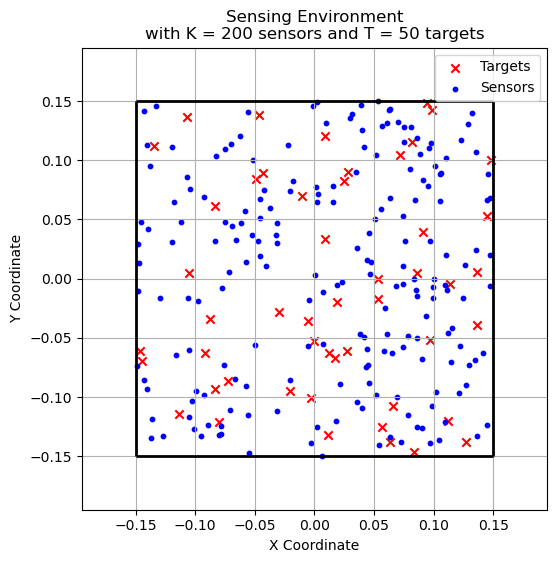

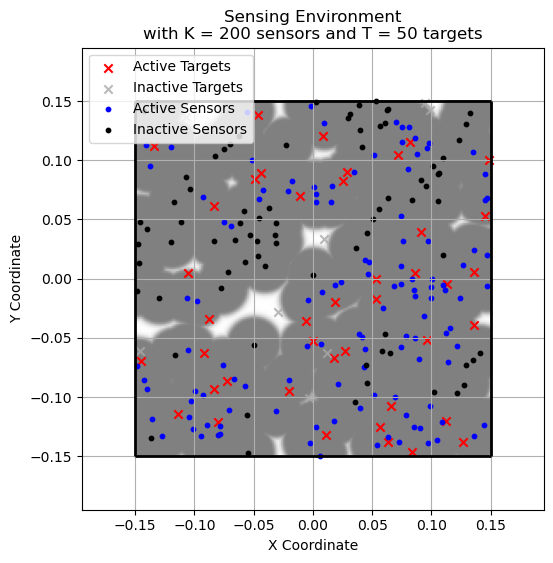

In [28]:
# Initialize Sensing Environment
sensing_env = tuma_mtl.SensingEnvironment(
    num_sensors=num_sensors, num_targets=num_targets, 
    area_side=area_side, sigma_noise=sigma_noise, 
    perfect_measurement=perfect_measurement, max_detections_per_sensor=max_detections_per_sensor,
    Ns=N_s, Ps=P_s, sigma_n=sigma_n, S=S, fc=fc, gamma=gamma
)
sensing_env.visualize_initial_setup()

# Run sensing simulation
sensing_env.run_sensing()
sensing_env.visualize_alternative()

## 📊 Detection Statistics

Now, we analyze the detection results:
- Number of **detected targets per sensor**.
- Number of **active sensors** (sensors that detected at least one target).
- Number of **active targets** (targets that were detected by at least one sensor).

We also visualize the **active sensors and active targets**.

Total Detections: 120
Total Active Targets: 42
Percentage of Active Targets: 84.0
Average Detections per Sensor: 0.6
Max Detections by a Sensor: 1
Number of Active Sensors: 120
Percentage of Active Sensors: 60.0


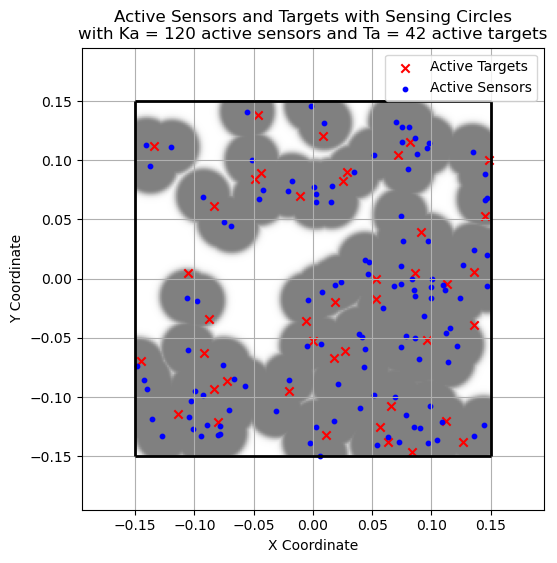

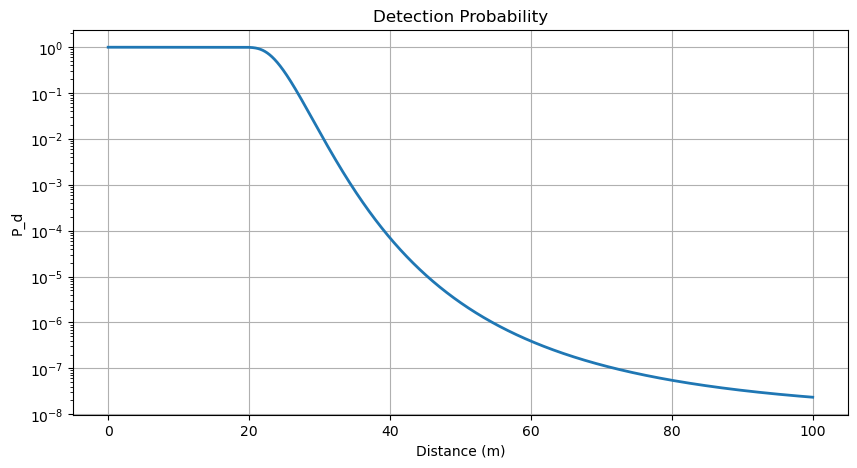

In [29]:
# Get detection statistics
sensing_stats = sensing_env.get_detection_statistics()

# Display statistics
for key, value in sensing_stats.items():
    print(f"{key}: {value}")

# Visualize active sensors and targets
sensing_env.visualize_active_alternative()

# Visualize detection probability
sensing_env.visualize_detection_probability()

## 🌍 Network Topology

We now **set up the network topology**, defining:
- **Zones (U)**
- **Access Points (B)** positioned at zone boundaries.

The topology is **automatically generated**, and we visualize the AP and zone placements.

Total Zones (U): 9
Total APs (B): 40


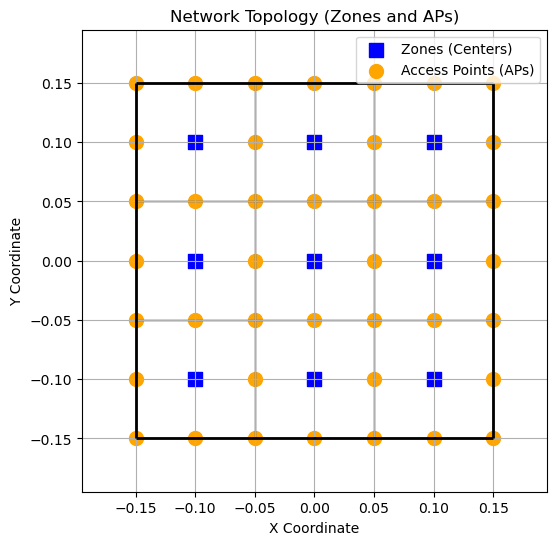

In [30]:
# Initialize network topology
topology = tuma_mtl.NetworkTopology(side_length=zone_side)

# Display total zones and APs
print(f"Total Zones (U): {topology.U}")
print(f"Total APs (B): {topology.B}")

# Visualize topology
topology.visualize()

## 🎛️ Quantization Process

In this section, we apply **quantization** to the detected target positions. 

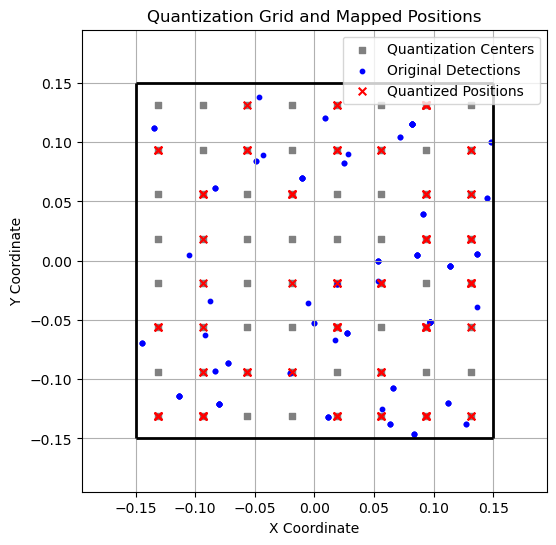

In [31]:
# Get targets and active sensors from sensing results
targets, active_sensors = sensing_env.get_targets_and_active_sensors()

# Initialize Quantization Environment
quant_env = tuma_mtl.QuantizationEnvironment(active_sensors, quantization_levels=M, area_side=area_side)

# Apply quantization
quant_env.apply_quantization()

# Visualize the quantization results
quant_env.visualize_quantization()

## 📡 TUMA Communication - Transmission

In this section, we define the **communication model** and simulate the transmission of quantized sensor data in the **TUMA (Type-Based Unsourced Multiple Access) framework**.

Zone 0: Unique Messages = 6, Total Sensors = 20
Zone 1: Unique Messages = 4, Total Sensors = 12
Zone 2: Unique Messages = 5, Total Sensors = 18
Zone 3: Unique Messages = 3, Total Sensors = 4
Zone 4: Unique Messages = 4, Total Sensors = 9
Zone 5: Unique Messages = 7, Total Sensors = 24
Zone 6: Unique Messages = 4, Total Sensors = 6
Zone 7: Unique Messages = 4, Total Sensors = 12
Zone 8: Unique Messages = 5, Total Sensors = 15

Global Statistics:
Total Unique Messages: 42
Total Transmissions (Total Sensors): 120


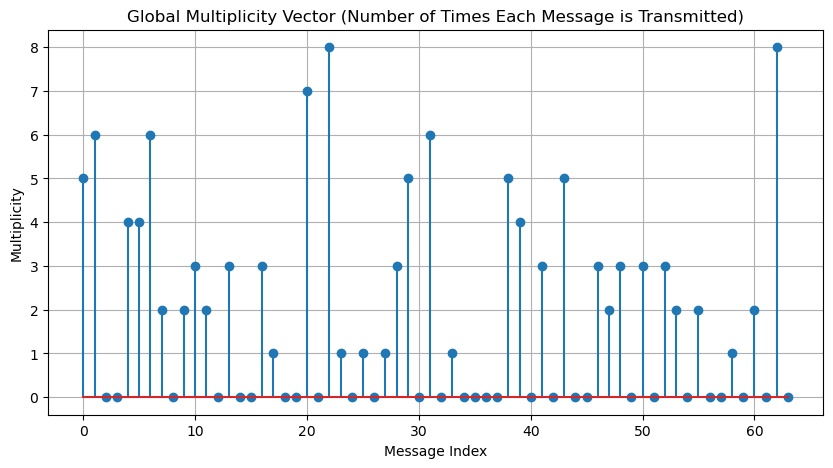

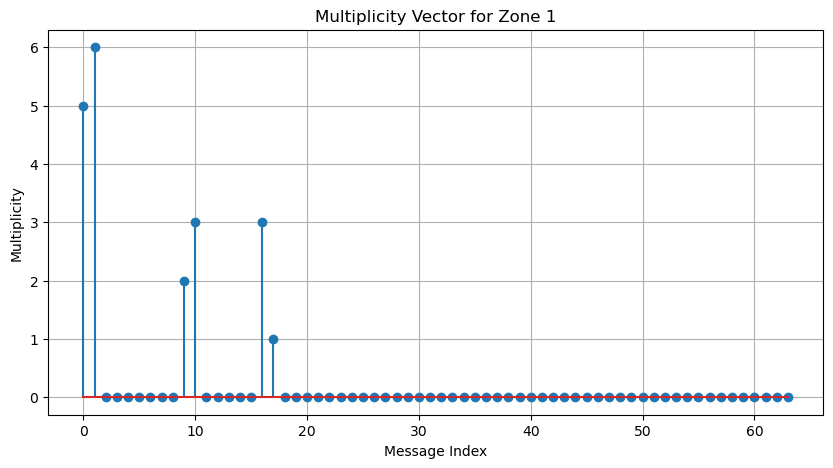

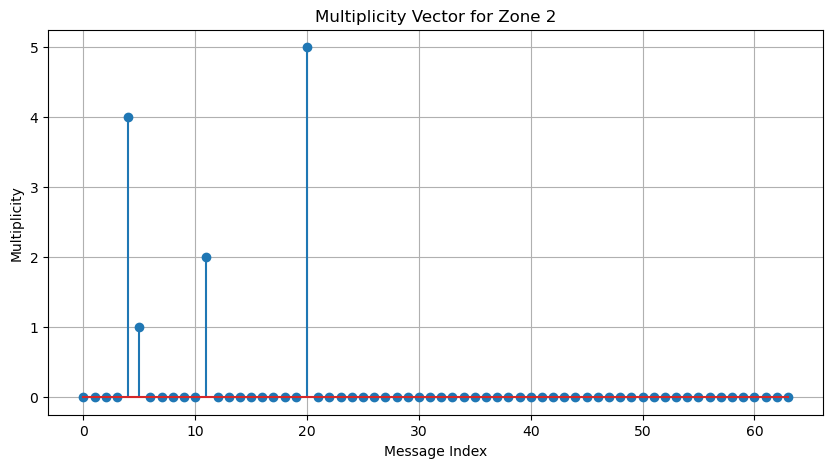

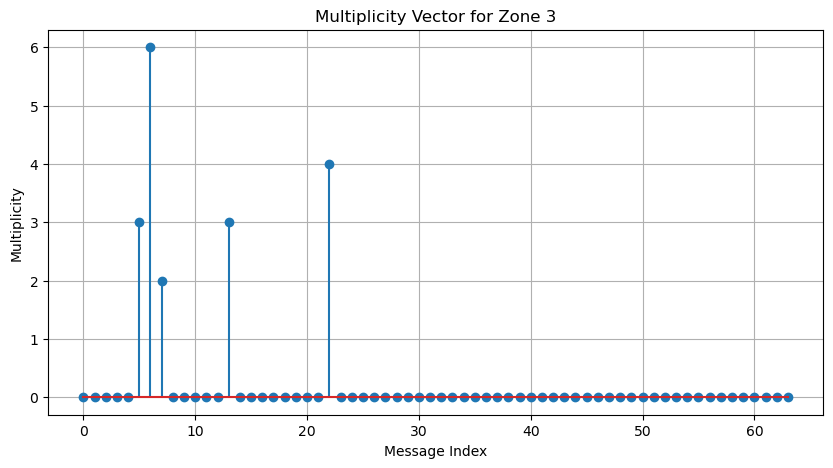

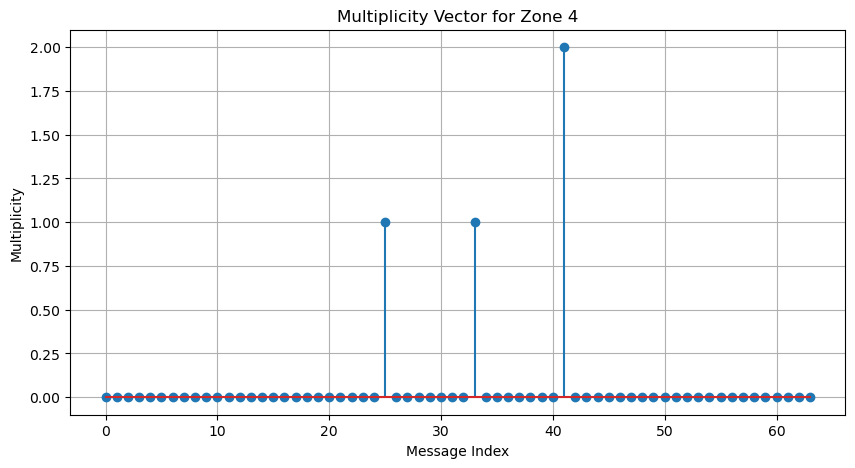

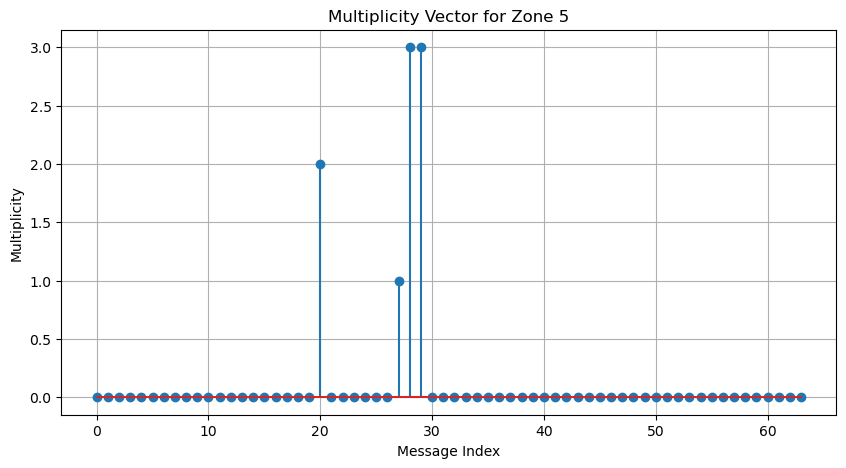

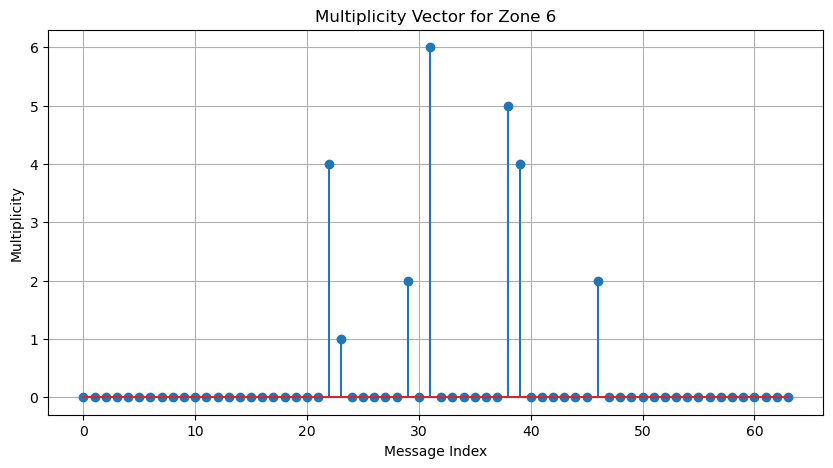

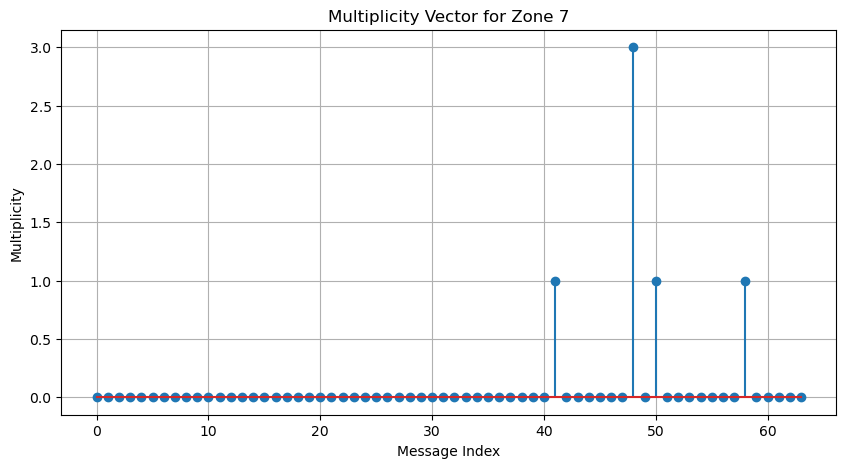

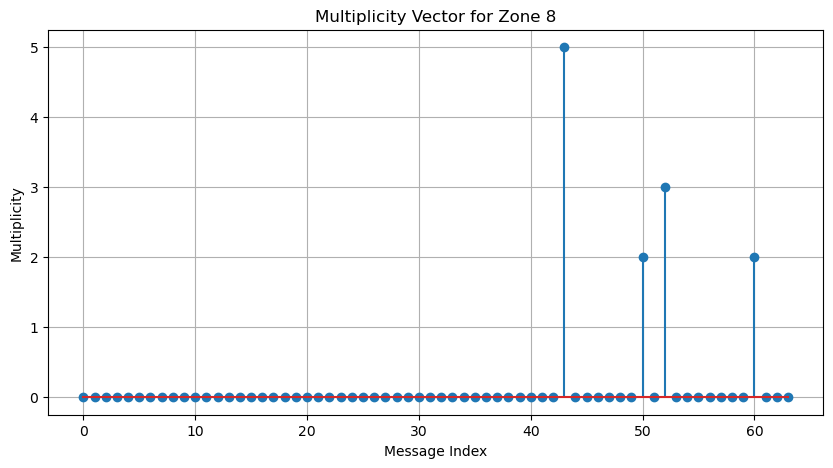

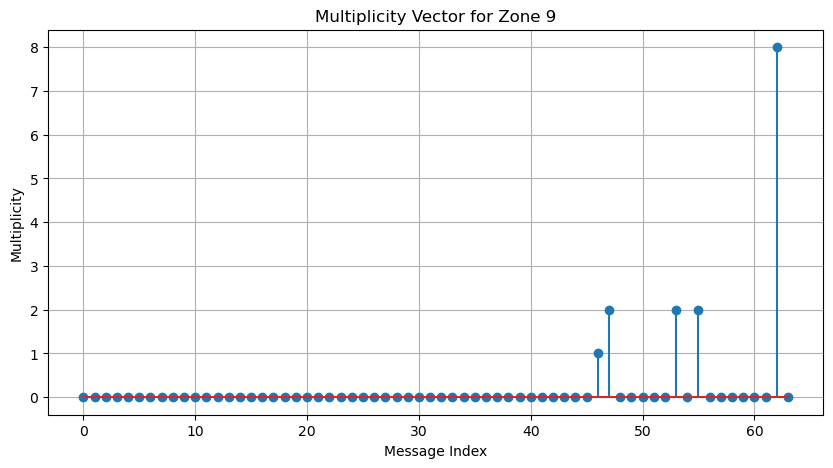

In [32]:
# Initialize TUMA environment
TUMA_env = tuma_mtl.TUMAEnvironment(num_targets, num_sensors, active_sensors, topology, N_c, M, A, M, rho, d0, SNR_rx_dB, P_c, nAMPiter, N_s, N_MC, N_MC_smaller, perfect_comm,
                           decoder_type=decoder_type, Kmax=Kmax)

# Compute Multiplicity Statistics (Per-Zone & Global)
zone_stats, global_stats = TUMA_env.compute_multiplicity_statistics()

# Print Per-Zone Statistics
for zone_id, stats in zone_stats.items():
    print(f"Zone {zone_id}: Unique Messages = {stats['unique_messages']}, Total Sensors = {stats['total_sensors']}")

# Print Global Statistics
print("\nGlobal Statistics:")
print(f"Total Unique Messages: {global_stats['total_unique_messages']}")
print(f"Total Transmissions (Total Sensors): {global_stats['total_transmissions']}")

# Visualize Multiplicity Vector
TUMA_env.visualize_multiplicity_vector()
TUMA_env.visualize_multiplicity_vector_per_zone()

# Perform Transmission and Obtain Received Signal Y
TUMA_env.transmit()

## 🔄📊  TUMA Communication - Decoder with Performance Results

Loading prior data from ./prior_data/priors_T50_K200_J6_Ns1000.npz ...
		AMP iteration: 1/10
		AMP iteration: 2/10
		AMP iteration: 3/10
		AMP iteration: 4/10
		AMP iteration: 5/10
		AMP iteration: 6/10
channel_est_perfs = [0.14030583883467113, 0.001900145889199709, 9.36073570582823e-05, 1.2706388659614173e-05, 6.363681296772608e-06, 5.788190530001945e-06, 5.7141545436365345e-06]
channel_est_T_perfs = [0.13998499405063575, 0.0018403620682805192, 7.941214095108818e-05, 5.094021411686746e-06, 4.663135640068079e-06, 5.277396634932215e-06, 5.3533596616358934e-06]


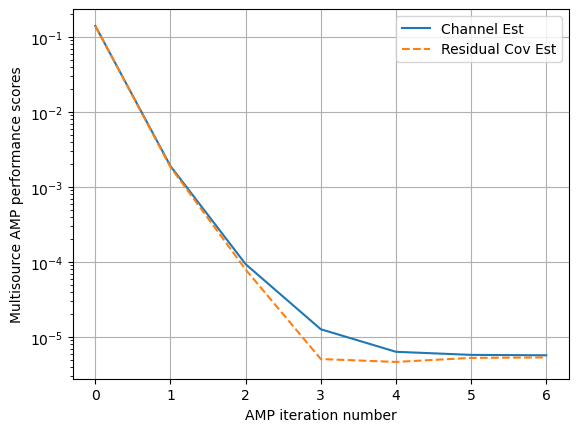

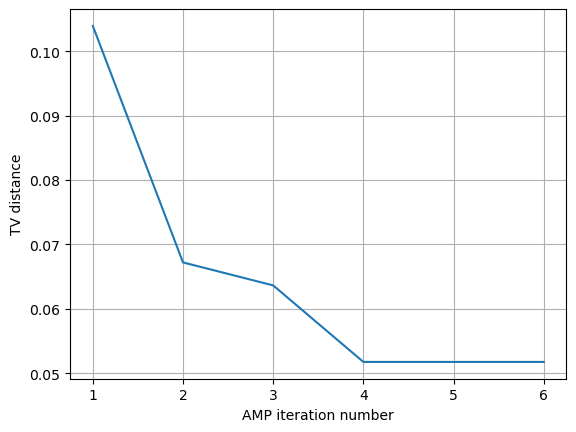

Performance results:
	tv distance = 0.0447
	empirical p_md = 0.1600
	ws distance = 19.9345 m
	GOSPA-like cost: 24.9476 m


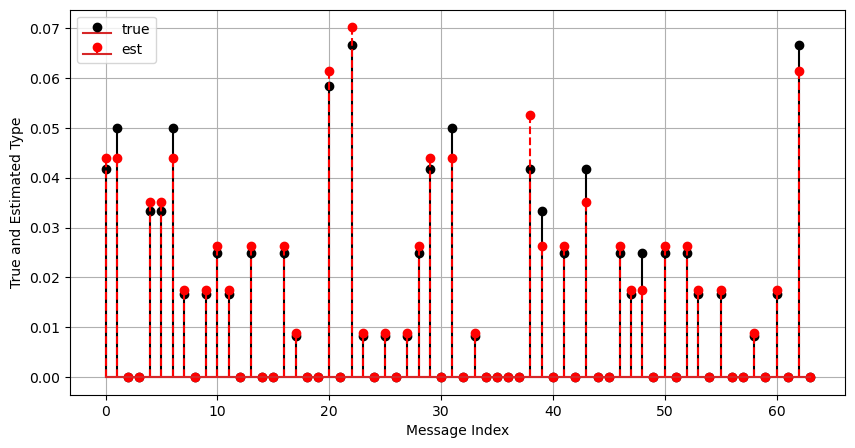

In [33]:
# Centralized decoder
TUMA_env.decoder(withOnsager, plot_perf=True)

# i) tv distance for comm errors:
tv_dist = tuma_mtl.tv_distance(TUMA_env.true_type, TUMA_env.estimated_type)

# ii) empirical misdetection probability for sensing errors
# iii) wasserstein distance for comm + quant errors and GOSPA-like 
# iv) GOSPA-like metric for comm + quant + sensing errors
true_positions = [target.position for target in targets]
detected_positions, _, true_target_type = tuma_mtl.get_true_positions_and_type(active_sensors)

empirical_pmd, ws_dist, dGOSPAlike = tuma_mtl.compute_tuma_mtl_performance_metric(
    true_positions, 
    detected_positions, 
    quant_env.quantized_positions,
    true_target_type,
    TUMA_env.estimated_type,
    c=c,
    p=p
)

print(f"Performance results:\n\ttv distance = {tv_dist:.4f}\n\tempirical p_md = {empirical_pmd:.4f}\n\tws distance = {ws_dist*1000:.4f} m\n\tGOSPA-like cost: {dGOSPAlike*1000:.4f} m")
TUMA_env.visualize_type_estimation()